#Feed Forward NN Classifier with Twitter Covid Vaccination Data

**Mount Google Drive(to read the datasets)**

We will first mount the google drive storage to load the datasets. It is not necessary, but I did it this way in order to avoid uploading them every time. If you want, you can upload yours and just change the import paths. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import necessary libraries**

Then, we will import the necessary libraries


In [ ]:
import pandas as pd
import re
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve, auc

pd.set_option('max_colwidth', 500)
%matplotlib inline

**Set random seed**

Set a constant random seed in order to get the same (deterministic) outputs every time we run our models.

In [ ]:
seed = 17064
def reset_seed():
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
reset_seed()

**Enable CUDA**

Enable CUDA for GPU utilization by our model. This makes calculations and thus the training of our models faster.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset loading
Now, let's load our datasets:

**Train Dataset**

In [ ]:
train_dataset = pd.read_csv('gdrive/MyDrive/NLP exercises/Datasets/Twitter Covid Vaccination data/vs_train.csv')
train_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
train_dataset

,tweet,label
0,Sip N Shop Come thru right now #Marjais #PopularNobodies #MMR 🙌🙌🙌🙌 @ Marjais SipNShop http://t.co/JfWAH7uzWE,0
1,I don't know about you but My family and I will not take the #Covid19 vaccine anytime soon...,1
2,"@MSignorile Immunizations should be mandatory. Period. In Oklahoma, they won't let kids go to school without them. It's dangerous otherwise!",2
3,"President Obama spoke in favor of vaccination for children. Fox will start telling its viewers to ""choose"" against vaccination in 3,2,1...",0
4,"""@myfoxla: Arizona monitoring hundreds for measles linked to Disneyland http://t.co/tEoU2zAQat"" It's a Small World After All.",0
...,...,...
15971,@Salon if u believe the anti-vax nutcases caused measles u are ignoring the Obama illegal children who streamed to the US. coincidence?,1
15972,How do you feel about parents who don't #vaccinate their kids?\r\nhttps://t.co/k3O7Al8Au3\r\n#MeaslesOutbreak,0
15973,70 Preschoolers Tested for Measles in Simi Valley http://t.co/pTRjYu8SVr,0
15974,"Finance Minister: Budget offers room to procure COVID-19 vaccines, if available https://t.co/VLdKXat3NJ",0


**Validation Dataset**

In [ ]:
validation_dataset = pd.read_csv('gdrive/MyDrive/NLP exercises/Datasets/Twitter Covid Vaccination data/vs_dev.csv')
validation_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
validation_dataset

,tweet,label
0,"@user They had a massive surge in with covid deaths immediately after the vaccine rollout, way more than they had during the entirety of the ""pandemic"" up to that point. Fuck those jabs, Dr.Death.",1
1,Required vaccines for school: Parents and guardians of children with school exclusion letters now have an... http://t.co/KVl8Dt86dz,0
2,“@KCStar: Two more Johnson County children have measles http://t.co/Rvx07sc” @sethmnookin,0
3,"NV can do better. Which states are the best (and worst) at vaccinating their kids http://t.co/6GaZGgYA9z http://t.co/pTFRJZ2Tmr""",2
4,Nothing like killing ourselves w/ our own fear MT@Alyssa_Milano: Vaccine fears have fueled the resurgence of preventable diseases.,2
...,...,...
2277,"RT @abc7: Number of measles cases reported in Cali is at a 10-year high, officials say http://t.co/J4tqBkJl uggh not a good thing at all!!",0
2278,"Evidence points to the idea that ""measles affects the immune system for two to three years"" after the disease. http://t.co/DbjIQVLQrS",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you should vaccinate your kids, in two minutes: http://t.co/HrZPqQERkY""",2
2280,"Some of my favorite people have autism. If that's your reason for bringing back diseases we have eviscerated, fuck you. #vaccineswork",2


**Test Dataset**

Note: I used the same dataset as the validation, because the assignment's test set was hidden. You can plug your own just by changing the path.

In [ ]:
test_dataset = pd.read_csv('gdrive/MyDrive/NLP exercises/Datasets/Twitter Covid Vaccination data/vs_dev.csv')
test_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
test_dataset

,tweet,label
0,"@user They had a massive surge in with covid deaths immediately after the vaccine rollout, way more than they had during the entirety of the ""pandemic"" up to that point. Fuck those jabs, Dr.Death.",1
1,Required vaccines for school: Parents and guardians of children with school exclusion letters now have an... http://t.co/KVl8Dt86dz,0
2,“@KCStar: Two more Johnson County children have measles http://t.co/Rvx07sc” @sethmnookin,0
3,"NV can do better. Which states are the best (and worst) at vaccinating their kids http://t.co/6GaZGgYA9z http://t.co/pTFRJZ2Tmr""",2
4,Nothing like killing ourselves w/ our own fear MT@Alyssa_Milano: Vaccine fears have fueled the resurgence of preventable diseases.,2
...,...,...
2277,"RT @abc7: Number of measles cases reported in Cali is at a 10-year high, officials say http://t.co/J4tqBkJl uggh not a good thing at all!!",0
2278,"Evidence points to the idea that ""measles affects the immune system for two to three years"" after the disease. http://t.co/DbjIQVLQrS",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you should vaccinate your kids, in two minutes: http://t.co/HrZPqQERkY""",2
2280,"Some of my favorite people have autism. If that's your reason for bringing back diseases we have eviscerated, fuck you. #vaccineswork",2


# Data Visualization
And now, we will visualize the amount of tweets of each label on our datasets to get a brief overview about their distribution.

**Train dataset**

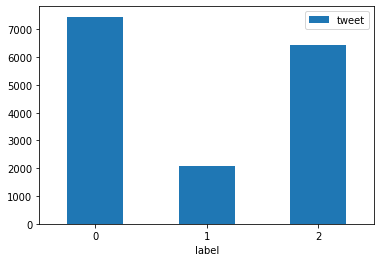

In [ ]:
trainLabelCounts = train_dataset.groupby('label').count()
trainLabelCounts.plot.bar(rot=0)

**Validation dataset**

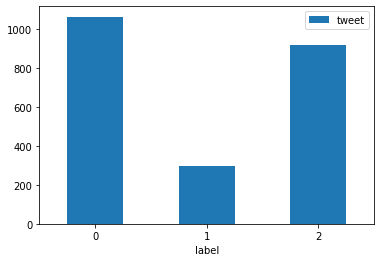

In [ ]:
validationLabelCounts = validation_dataset.groupby('label').count()
validationLabelCounts.plot.bar(rot=0)

**Test Dataset**

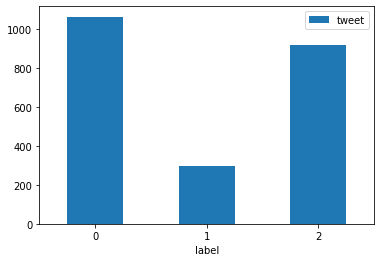

In [ ]:
testLabelCounts = test_dataset.groupby('label').count()
testLabelCounts.plot.bar(rot=0)

As you can see, there are not as many label 1 (anti-vax) tweets as the other two classes. So, we expect less score in class 1.

# Text Preprocessing
Now, we will clean our tweets from useless information in order to make a good vectorization later. More specifically, we will remove tags, urls, punctuation (except ' and ’ because we will need them to remove stopwords like it's), underscore(_) characters, whitespace, single characters, numbers, and we will convert the texts to lowercase because all words are the same in both upper and lower cases. Note that we will keep the hashtags(without the # symbol), because they contain useful information about the tweets.

In [ ]:
def text_preprocessing(text: str):
  # Remove tags
  text = re.sub(r'@\s?\w+',' ',text)
  # Remove urls
  text = re.sub(r'https?://\S+',' ',text)
  # Remove punctuation(except ' and ’)
  text = re.sub(r'[^’\'\s\w]',' ',text)
  # Remove underscore characters
  text = re.sub(r'_', ' ', text)
  # Remove \r and \n
  text = re.sub(r'[\r\n]',' ', text)
  # Remove single characters
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ',text)
  # Remove single characters from start
  text = re.sub(r'^[a-zA-Z]\s+', '', text)
  # Remove single characters from end
  text = re.sub(r'\s+[a-zA-Z]$', '', text)
  # Remove numbers
  text = re.sub(r'\d+',' ',text)
  # Convert multiple spaces to single space and remove beginning and end spaces
  text = re.sub(r' +',' ',text).strip()
  # Convert to lowercase
  text = text.lower()

  return text

**Train Dataset**

In [ ]:
train_dataset['tweet'] = train_dataset['tweet'].apply(lambda tweet: text_preprocessing(tweet))
train_dataset

,tweet,label
0,sip shop come thru right now marjais popularnobodies mmr sipnshop,0
1,don't know about you but my family and will not take the covid vaccine anytime soon,1
2,immunizations should be mandatory period in oklahoma they won't let kids go to school without them it's dangerous otherwise,2
3,president obama spoke in favor of vaccination for children fox will start telling its viewers to choose against vaccination in,0
4,arizona monitoring hundreds for measles linked to disneyland it's small world after all,0
...,...,...
15971,if believe the anti vax nutcases caused measles are ignoring the obama illegal children who streamed to the us coincidence,1
15972,how do you feel about parents who don't vaccinate their kids measlesoutbreak,0
15973,preschoolers tested for measles in simi valley,0
15974,finance minister budget offers room to procure covid vaccines if available,0


**Validation Dataset**

In [ ]:
validation_dataset['tweet'] = validation_dataset['tweet'].apply(lambda tweet: text_preprocessing(tweet))
validation_dataset

,tweet,label
0,they had massive surge in with covid deaths immediately after the vaccine rollout way more than they had during the entirety of the pandemic up to that point fuck those jabs dr death,1
1,required vaccines for school parents and guardians of children with school exclusion letters now have an,0
2,two more johnson county children have measles,0
3,nv can do better which states are the best and worst at vaccinating their kids,2
4,nothing like killing ourselves our own fear mt vaccine fears have fueled the resurgence of preventable diseases,2
...,...,...
2277,rt number of measles cases reported in cali is at year high officials say uggh not good thing at all,0
2278,evidence points to the idea that measles affects the immune system for two to three years after the disease,0
2279,where's why you should vaccinate your kids in two minutes,2
2280,some of my favorite people have autism if that's your reason for bringing back diseases we have eviscerated fuck you vaccineswork,2


**Test Dataset**

In [ ]:
test_dataset['tweet'] = test_dataset['tweet'].apply(lambda tweet: text_preprocessing(tweet))
test_dataset

,tweet,label
0,they had massive surge in with covid deaths immediately after the vaccine rollout way more than they had during the entirety of the pandemic up to that point fuck those jabs dr death,1
1,required vaccines for school parents and guardians of children with school exclusion letters now have an,0
2,two more johnson county children have measles,0
3,nv can do better which states are the best and worst at vaccinating their kids,2
4,nothing like killing ourselves our own fear mt vaccine fears have fueled the resurgence of preventable diseases,2
...,...,...
2277,rt number of measles cases reported in cali is at year high officials say uggh not good thing at all,0
2278,evidence points to the idea that measles affects the immune system for two to three years after the disease,0
2279,where's why you should vaccinate your kids in two minutes,2
2280,some of my favorite people have autism if that's your reason for bringing back diseases we have eviscerated fuck you vaccineswork,2


# Stopwords Removal
Now, we will remove some stopwords(words that do not have any important value for the texts) from all the tweets.

First, let's download the stopwords that we are going to remove:

In [ ]:
nltk.download('stopwords')
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

Then, let's remove them from our datasets:

In [ ]:
def remove_stopwords(text):
  tokens = text.split(' ')
  return ' '.join([w for w in tokens if w not in stopwords.words('english')])

In [ ]:
train_dataset['tweet'] = train_dataset['tweet'].apply(remove_stopwords)
train_dataset

,tweet,label
0,sip shop come thru right marjais popularnobodies mmr sipnshop,0
1,know family take covid vaccine anytime soon,1
2,immunizations mandatory period oklahoma let kids go school without dangerous otherwise,2
3,president obama spoke favor vaccination children fox start telling viewers choose vaccination,0
4,arizona monitoring hundreds measles linked disneyland small world,0
...,...,...
15971,believe anti vax nutcases caused measles ignoring obama illegal children streamed us coincidence,1
15972,feel parents vaccinate kids measlesoutbreak,0
15973,preschoolers tested measles simi valley,0
15974,finance minister budget offers room procure covid vaccines available,0


In [ ]:
validation_dataset['tweet'] = validation_dataset['tweet'].apply(remove_stopwords)
validation_dataset

,tweet,label
0,massive surge covid deaths immediately vaccine rollout way entirety pandemic point fuck jabs dr death,1
1,required vaccines school parents guardians children school exclusion letters,0
2,two johnson county children measles,0
3,nv better states best worst vaccinating kids,2
4,nothing like killing fear mt vaccine fears fueled resurgence preventable diseases,2
...,...,...
2277,rt number measles cases reported cali year high officials say uggh good thing,0
2278,evidence points idea measles affects immune system two three years disease,0
2279,where's vaccinate kids two minutes,2
2280,favorite people autism that's reason bringing back diseases eviscerated fuck vaccineswork,2


In [ ]:
test_dataset['tweet'] = test_dataset['tweet'].apply(remove_stopwords)
test_dataset

,tweet,label
0,massive surge covid deaths immediately vaccine rollout way entirety pandemic point fuck jabs dr death,1
1,required vaccines school parents guardians children school exclusion letters,0
2,two johnson county children measles,0
3,nv better states best worst vaccinating kids,2
4,nothing like killing fear mt vaccine fears fueled resurgence preventable diseases,2
...,...,...
2277,rt number measles cases reported cali year high officials say uggh good thing,0
2278,evidence points idea measles affects immune system two three years disease,0
2279,where's vaccinate kids two minutes,2
2280,favorite people autism that's reason bringing back diseases eviscerated fuck vaccineswork,2


# General model definition

We will now define the general model class for all the models we will experiment with (we will pass different parameters to get different layers,neurons and activation functions).

In [ ]:
class Model(nn.Module):
  def __init__(self, D_in: int, hiddenSizes: list, D_out: int, dropout_probability: int, activation_func: str, activation_func_arg: float = None):
    super(Model, self).__init__()
    self.linearLayers = []
    if len(hiddenSizes) > 0:
      self.linearLayers.append(nn.Linear(D_in, hiddenSizes[0], device=device))
      for i in range(1, len(hiddenSizes)):
        self.linearLayers.append(nn.Linear(hiddenSizes[i-1], hiddenSizes[i], device=device))
      self.linearLayers.append(nn.Linear(hiddenSizes[-1], D_out))
    else:
      self.linearLayers.append(nn.Linear(D_in, D_out, device=device))
    self.linearLayers = nn.ModuleList(self.linearLayers)
    if activation_func_arg is not None:
      self.activation = getattr(nn, activation_func)(activation_func_arg)
    else:
      self.activation = getattr(nn, activation_func)()
    self.dropout = nn.Dropout(p=dropout_probability)

  def forward(self, x):
    out = self.linearLayers[0](x)
    if len(self.linearLayers) > 1:
      out = self.activation(out)
      out = self.dropout(out)
    for i in range(1, len(self.linearLayers)):
      out = self.linearLayers[i](out)
      if i < len(self.linearLayers) - 1:
        out = self.activation(out)
        out = self.dropout(out)
    return out
  
  def accuracy(self, data: torch.tensor, true_labels: torch.tensor):
    with torch.no_grad():
      self.eval()
      outputs = self(data)
      _, predicted_labels = torch.max(outputs, 1)
      total = true_labels.size(0)
      correct = (true_labels == predicted_labels).sum().item()
      return 100 * correct / total

And then the training function.

In [ ]:
def train(model: Model, dataloader: torch.utils.data.DataLoader, X_val: torch.tensor, y_val: torch.tensor, learning_rate: float, epochs: int, optimizer: str):
  loss_function = nn.CrossEntropyLoss()
  opt = getattr(torch.optim, optimizer)(model.parameters(), lr=learning_rate)
  print("Using optimizer: ", opt)
  train_losses = []
  validation_losses = []
  for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in dataloader:
      y_pred = model(x_batch)
      loss = loss_function(y_pred, y_batch)
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #Update model's weights based on the gradients calculated during backprop
      opt.step()
      #Delete previously stored gradients
      opt.zero_grad()
    with torch.no_grad():
      model.eval()
      y_pred = model(X_val)
      val_loss = loss_function(y_pred, y_val)
      val_acc = model.accuracy(X_val, y_val)
      _, y_pred_labels = torch.max(y_pred, 1)
      f1 = f1_score(y_val.cpu(), y_pred_labels.cpu(), average='weighted')
      print(f"Epoch {epoch:3}: Loss = {loss.item():.5f} Val_loss = {val_loss:.5f} Val_accuracy = {val_acc:.5f} F1_Score = {f1:.5f}")
      train_losses.append(loss.item())
      validation_losses.append(val_loss)
  return train_losses, validation_losses

We will also define functions for scores computations and also evaluation processes.

In [ ]:
def plot_loss_vs_epochs(train_losses, val_losses):
  assert(len(train_losses) == len(validation_losses))
  plt.grid()
  plt.plot(list(range(len(train_losses))), train_losses, "o-", label="Train")
  plt.plot(list(range(len(train_losses))), validation_losses, "o-", label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
def evaluate_model(model: Model, X_test, y_test):
  with torch.no_grad():
    model.eval()
    _, y_pred = torch.max(model(X_test), 1)
    y_pred = y_pred.cpu()
    y_test = y_test.cpu()
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    cm = confusion_matrix(y_test, y_pred)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
    cm_disp.plot()
    plt.show()

In [ ]:
def plot_roc_curve(y_score: torch.tensor, y_test: torch.tensor):
  with torch.no_grad():
    y_score = softmax(y_score)
    y_test = label_binarize(y_test, classes=[0, 1, 2])

    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc= auc(fpr, tpr)

    plt.figure()
    plt.plot(
        fpr,
        tpr,
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc),
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], color="navy",lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

# Model comparison
We will make experiments with different feed-forward neural network models and compare each other's performance. The models are sorted from worst to best (best is last).

## Model 1: GloVe Wikipedia 300-dimensional word embeddings and Feed Forward NN with 2 hidden layers with 256 neurons each, CrossEntropyLoss function, ReLU activation, Adam optimizer.

First of all, we will use pre-trained word embeddings from GloVe and for each tweet's representation, we will take the median of all it's word vectors. I chose the Wikipedia dataset 300-dimensional word-vectors because it gave the best score compared to others. Note that i tried all the available dimensions of word-vectors but the biggest ones gave the best results because of the information they keep due to big dimension.

**Download GloVe embeddings**

In [27]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-12-23 17:38:32--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-23 17:38:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.13MB/s    in 2m 42s  

2021-12-23 17:41:15 (5.09 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

**Create Embeddings Dictionary**

In [28]:
embed_dict = {}
with open('glove.6B.300d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], 'float32')
    embed_dict[word] = vector

**Tweets Vectorization**


In [29]:
def vectorize_with_word_embeddings(X_values, y_values, embed_dict):
  X = []
  y = []
  for idx, tweet in enumerate(X_values):
    tweet_embeddings = []
    for word in tweet.split(' '):
      if word in embed_dict:
        tweet_embeddings.append(list(embed_dict[word]))
    # Ignore tweets that do not have any word embeddings
    if len(tweet_embeddings) > 0:
      X.append(list(np.mean(tweet_embeddings, axis=0)))
      y.append(y_values[idx])
  X = torch.tensor(np.asarray(X), dtype=torch.float, device=device)
  y = torch.tensor(np.asarray(y), device=device)
  print(X.shape, y.shape)
  return X, y

In [81]:
X_train, y_train = vectorize_with_word_embeddings(train_dataset['tweet'].values, train_dataset['label'].values, embed_dict)

torch.Size([15972, 300]) torch.Size([15972])


In [82]:
X_val, y_val = vectorize_with_word_embeddings(validation_dataset['tweet'].values, validation_dataset['label'].values, embed_dict)

torch.Size([2281, 300]) torch.Size([2281])


In [83]:
X_test, y_test = vectorize_with_word_embeddings(test_dataset['tweet'].values, test_dataset['label'].values, embed_dict)

torch.Size([2281, 300]) torch.Size([2281])


In [84]:
reset_seed()

In [85]:
model = Model(X_train.shape[1], [256, 256], 3, dropout_probability=0.7, activation_func="ReLU").to(device)
model

Model(
  (linearLayers): ModuleList(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.7, inplace=False)
)

In [86]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024)

In [87]:
train_losses, validation_losses = train(model, dataloader, X_val, y_val, learning_rate=0.002, epochs=19, optimizer="Adam")

Using optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
Epoch   0: Loss = 0.85272 Val_loss = 0.82368 Val_accuracy = 63.56861 F1_Score = 0.59296
Epoch   1: Loss = 0.78767 Val_loss = 0.76361 Val_accuracy = 67.07584 F1_Score = 0.62691
Epoch   2: Loss = 0.75596 Val_loss = 0.74030 Val_accuracy = 67.20737 F1_Score = 0.62845
Epoch   3: Loss = 0.73514 Val_loss = 0.72607 Val_accuracy = 67.82113 F1_Score = 0.63498
Epoch   4: Loss = 0.74367 Val_loss = 0.71457 Val_accuracy = 68.69794 F1_Score = 0.64300
Epoch   5: Loss = 0.71347 Val_loss = 0.70538 Val_accuracy = 68.91714 F1_Score = 0.64827
Epoch   6: Loss = 0.70200 Val_loss = 0.70028 Val_accuracy = 69.70627 F1_Score = 0.66611
Epoch   7: Loss = 0.69278 Val_loss = 0.69487 Val_accuracy = 70.67076 F1_Score = 0.69313
Epoch   8: Loss = 0.66670 Val_loss = 0.68952 Val_accuracy = 70.75844 F1_Score = 0.69694
Epoch   9: Loss = 0.66542 Val_loss = 0.68452 Val_accuracy = 70.84612 F1

In [88]:
print(f"Train Accuracy = {model.accuracy(X_train, y_train)}")
print(f"Test Accuracy = {model.accuracy(X_test, y_test)}")

Train Accuracy = 78.39343851740546
Test Accuracy = 73.12582200789127


              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1064
           1       0.53      0.46      0.49       296
           2       0.68      0.79      0.73       921

    accuracy                           0.73      2281
   macro avg       0.68      0.67      0.67      2281
weighted avg       0.74      0.73      0.73      2281

Precision: 0.7356416186144834
Recall: 0.7312582200789127
F1 Score: 0.730647307987311


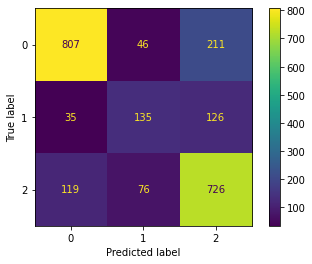

In [89]:
evaluate_model(model, X_test, y_test)

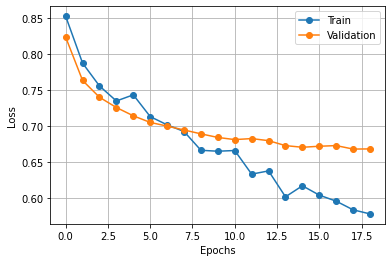

In [90]:
plot_loss_vs_epochs(train_losses, validation_losses)

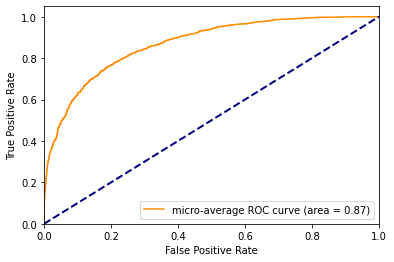

In [91]:
plot_roc_curve(model(X_test).cpu(), y_test.cpu())

As you can see, we got a bit better f1 score and more uniformly distributed correct predictions compared to the best softmax regression model from the previous assignment which gave f1_score=0.7296732963585068. This may be because of the more complex and with more degrees model compared to the softmax regression one. That's a good sign.

## Model 2: Tf-Idf vectorizer with min_df=4, max_df=0.3 and Feed Forward NN with 1 hidden layer with 2048 neurons, CrossEntropyLoss function, ReLU activation, Adam optimizer.

Now, let's try a different approach. I will use the tf-idf vectorizer with the same parameters that i used in the previous assignment, but this time with a feed-forward neural network with the parameters specified above.

**Text Vectorization**

We will convert all the tweets to pytorch tensors in order to be used by our neural network.

In [92]:
vectorizer = TfidfVectorizer(min_df=4, max_df=0.3).fit(train_dataset['tweet'].values)

In [93]:
X_train = torch.tensor(vectorizer.transform(train_dataset['tweet'].values).todense(), dtype=torch.float, device=device)
X_train.shape

torch.Size([15976, 4721])

In [94]:
y_train = torch.tensor(train_dataset['label'].values, device=device)
y_train

tensor([0, 1, 2,  ..., 0, 0, 2], device='cuda:0')

In [95]:
X_val = torch.tensor(vectorizer.transform(validation_dataset['tweet'].values).todense(), dtype=torch.float, device=device)
X_val.shape

torch.Size([2282, 4721])

In [96]:
y_val = torch.tensor(validation_dataset['label'].values, device=device)
y_val

tensor([1, 0, 0,  ..., 2, 2, 0], device='cuda:0')

In [97]:
X_test = torch.tensor(vectorizer.transform(test_dataset['tweet'].values).todense(), dtype=torch.float, device=device)
X_test.shape

torch.Size([2282, 4721])

In [98]:
y_test = torch.tensor(test_dataset['label'].values, device=device)
y_test

tensor([1, 0, 0,  ..., 2, 2, 0], device='cuda:0')

**Model Definition**

In [104]:
reset_seed()

In [105]:
model = Model(X_train.shape[1], [2048], 3, dropout_probability=0.85, activation_func="ReLU").to(device)
model

Model(
  (linearLayers): ModuleList(
    (0): Linear(in_features=4721, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=3, bias=True)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.85, inplace=False)
)

In [106]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024)

**Training Phase**

In [107]:
train_losses, validation_losses = train(model, dataloader, X_val, y_val, learning_rate=0.0009, epochs=9, optimizer="Adam")

Using optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0009
    weight_decay: 0
)
Epoch   0: Loss = 0.96555 Val_loss = 0.94636 Val_accuracy = 59.85977 F1_Score = 0.53555
Epoch   1: Loss = 0.83916 Val_loss = 0.82189 Val_accuracy = 68.18580 F1_Score = 0.63412
Epoch   2: Loss = 0.70570 Val_loss = 0.72517 Val_accuracy = 68.53637 F1_Score = 0.63871
Epoch   3: Loss = 0.63934 Val_loss = 0.69086 Val_accuracy = 68.93076 F1_Score = 0.64613
Epoch   4: Loss = 0.56728 Val_loss = 0.67268 Val_accuracy = 71.42857 F1_Score = 0.69460
Epoch   5: Loss = 0.52613 Val_loss = 0.66283 Val_accuracy = 72.65557 F1_Score = 0.71811
Epoch   6: Loss = 0.47950 Val_loss = 0.66206 Val_accuracy = 72.83085 F1_Score = 0.72357
Epoch   7: Loss = 0.44038 Val_loss = 0.66728 Val_accuracy = 73.04996 F1_Score = 0.72743
Epoch   8: Loss = 0.42241 Val_loss = 0.67607 Val_accuracy = 73.26906 F1_Score = 0.73029


**Model Evaluation**

In [108]:
print(f"Train Accuracy = {model.accuracy(X_train, y_train)}")
print(f"Test Accuracy = {model.accuracy(X_test, y_test)}")

Train Accuracy = 84.3264897346019
Test Accuracy = 73.26906222611744


              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1065
           1       0.64      0.50      0.56       296
           2       0.71      0.74      0.72       921

    accuracy                           0.73      2282
   macro avg       0.71      0.68      0.69      2282
weighted avg       0.73      0.73      0.73      2282

Precision: 0.7303047871197413
Recall: 0.7326906222611744
F1 Score: 0.7302920614855655


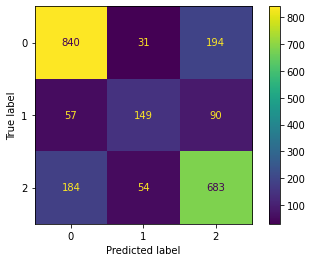

In [109]:
evaluate_model(model, X_test, y_test)

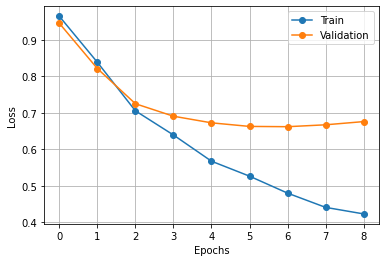

In [110]:
plot_loss_vs_epochs(train_losses, validation_losses)

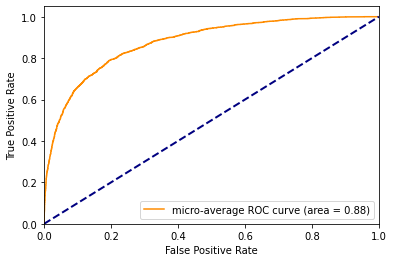

In [111]:
plot_roc_curve(model(X_test).cpu(), y_test.cpu())

As you can see, we got better accuracy score compared to the previous model and also the area under the roc curve is bigger by 0.01 unit. So, i will continue the experiments with this approach.

## Model 3 (best model): Tf-Idf vectorizer with min_df=4, max_df=0.3 and Feed Forward NN with 1 hidden layer with 2048 neurons, CrossEntropyLoss function, LeakyReLU activation, Adamax optimizer.

After a lot of experiments, i did not managed to increase the f1 score by modifying the neural network neurons, batch size, dropout and learning rate, so i decided to experiment with different optimizer and activation functions. After a few experiments, i managed to increase the f1 score of the previous model by changing the activation function to LeakyReLU with negative slope=0.001, and the optimizer to Adamax. I also changed the training epochs in order to reach a good training point.

**Text Vectorization**

We will convert all the tweets to pytorch tensors in order to be used by our neural network.

In [113]:
vectorizer = TfidfVectorizer(min_df=4, max_df=0.3).fit(train_dataset['tweet'].values)

In [114]:
X_train = torch.tensor(vectorizer.transform(train_dataset['tweet'].values).todense(), dtype=torch.float, device=device)
X_train.shape

torch.Size([15976, 4721])

In [115]:
y_train = torch.tensor(train_dataset['label'].values, device=device)
y_train

tensor([0, 1, 2,  ..., 0, 0, 2], device='cuda:0')

In [116]:
X_val = torch.tensor(vectorizer.transform(validation_dataset['tweet'].values).todense(), dtype=torch.float, device=device)
X_val.shape

torch.Size([2282, 4721])

In [117]:
y_val = torch.tensor(validation_dataset['label'].values, device=device)
y_val

tensor([1, 0, 0,  ..., 2, 2, 0], device='cuda:0')

In [118]:
X_test = torch.tensor(vectorizer.transform(test_dataset['tweet'].values).todense(), dtype=torch.float, device=device)
X_test.shape

torch.Size([2282, 4721])

In [119]:
y_test = torch.tensor(test_dataset['label'].values, device=device)
y_test

tensor([1, 0, 0,  ..., 2, 2, 0], device='cuda:0')

**Model Definition**

In [120]:
reset_seed()

In [121]:
model = Model(X_train.shape[1], [2048], 3, dropout_probability=0.85, activation_func="LeakyReLU", activation_func_arg=0.001).to(device)
model

Model(
  (linearLayers): ModuleList(
    (0): Linear(in_features=4721, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=3, bias=True)
  )
  (activation): LeakyReLU(negative_slope=0.001)
  (dropout): Dropout(p=0.85, inplace=False)
)

In [122]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024)

**Training Phase**

In [123]:
train_losses, validation_losses = train(model, dataloader, X_val, y_val, learning_rate=0.0009, epochs=23, optimizer="Adamax")

Using optimizer:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0009
    weight_decay: 0
)
Epoch   0: Loss = 1.00598 Val_loss = 0.99416 Val_accuracy = 57.09904 F1_Score = 0.49585
Epoch   1: Loss = 0.93942 Val_loss = 0.92242 Val_accuracy = 58.76424 F1_Score = 0.52082
Epoch   2: Loss = 0.88278 Val_loss = 0.86771 Val_accuracy = 66.38913 F1_Score = 0.61404
Epoch   3: Loss = 0.82086 Val_loss = 0.81148 Val_accuracy = 68.05434 F1_Score = 0.63353
Epoch   4: Loss = 0.75929 Val_loss = 0.76771 Val_accuracy = 68.40491 F1_Score = 0.63737
Epoch   5: Loss = 0.72577 Val_loss = 0.73849 Val_accuracy = 68.75548 F1_Score = 0.64119
Epoch   6: Loss = 0.69501 Val_loss = 0.71915 Val_accuracy = 68.84312 F1_Score = 0.64270
Epoch   7: Loss = 0.66917 Val_loss = 0.70512 Val_accuracy = 69.10605 F1_Score = 0.64808
Epoch   8: Loss = 0.64916 Val_loss = 0.69404 Val_accuracy = 69.63190 F1_Score = 0.65824
Epoch   9: Loss = 0.62325 Val_loss = 0.68481 Val_accuracy = 70.11394 F1_Score = 0.67139

**Model Evaluation**

In [124]:
print(f"Train Accuracy = {model.accuracy(X_train, y_train)}")
print(f"Test Accuracy = {model.accuracy(X_test, y_test)}")

Train Accuracy = 81.8915873810716
Test Accuracy = 73.79491673970202


              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1065
           1       0.64      0.47      0.54       296
           2       0.71      0.76      0.73       921

    accuracy                           0.74      2282
   macro avg       0.71      0.67      0.69      2282
weighted avg       0.73      0.74      0.73      2282

Precision: 0.7347964133252263
Recall: 0.7379491673970202
F1 Score: 0.734242890146098


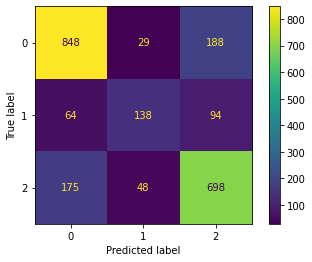

In [128]:
evaluate_model(model, X_test, y_test)

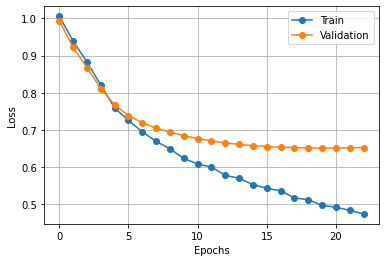

In [126]:
plot_loss_vs_epochs(train_losses, validation_losses)

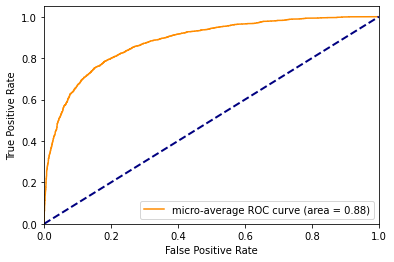

In [127]:
plot_roc_curve(model(X_test).cpu(), y_test.cpu())

As you can see, we got bigger f1 score and true predictions compared to the previous models, but i didn't manage to get a higher score, because these algorithms are not the best for text processing as they do not keep the order of the words in the text which is very important, but we know that LSTMs do and i will experiment with those in the next assignment. Also, regarding to the loss function, i didn't try another one, because we know CrossEntropyLoss is the best for multi-class problems.